Training a neural network, data is often processed in batches. For this reason, it is convenient to load the data in a

```
for epoch in range(epochs):
    for x_batch, y_batch in data:
        train
```
fashion, where `x_batch, y_batch` contain respectively a batch of samples features and labels.

If we have something like:

In [220]:
X = [1,2,3,4]

y = [0,0,1,1]

data = X, y


In [221]:
y

[0, 0, 1, 1]

we don't get the desired behaviour. In fact:

In [222]:
# for x, y in data:
#     print(x)
#     print(y)

A way to achieve it is by using the `zip` function:

In [223]:
data = zip(X,y)
data

In [224]:
for x, y in zip(X, y):
    print(x, y)

1 0
2 0
3 1
4 1


Now it's much better! But what if we want to adjust everything in batches? What if we have data that are indexed in a csv file?
What if we have images and we want to apply transformation to the data in the exact moment when we load them to process them? (The alternative is to preprocess all of them before loading it: it may cause a lot of storage usage! In fact, if you want to perform data augmentation for images for example, you will create a lot of copies - with slight changes - of the data!)

When you have used Pytorch so far you have loaded standard datasets (MNIST, FashionMNIST...) and you have taken advantage of the Pytorch Dataloader already. Let's do the same for a custom dataset, but for that we need to override some of the method given by that class.

As usual, we import the needed libraries:

In [225]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt

We need to inherit from the Dataset class (that we have imported from torch.utils.data):

In [226]:
class CustomDataset(Dataset):
    pass

Awesome! Now we need to override our constructor and the `__getitem__` method. What is this about? It is the method that allows your CustomDataset to be *indexed* in a `dataset[i]` fashion.

In addition, we want to override the `__len__` method as well, that is the method that returns the amount of data samples in the dataset that we are processing.

Ok but the shuffling?! *I want to shuffle the data!* Don't worry, the rest of the methods from the `Dataset`class will still be working!

In [227]:
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        pass
    def __getitem__(self, index):
        # we want to be index like dataset[index]
        # to get the index-th batch
        pass
    def __len__(self):
        # to retrieve the total samples by doing len(dataset)
        pass

As you can see, in the constructor I added `csv_file` as argument. The reason is that I want to create a dataloader for a dataset containing houses information.

In [228]:
dataset_path = "https://people.sc.fsu.edu/~jburkardt/data/csv/homes.csv"

In [229]:
import pandas as pd

df = pd.read_csv(dataset_path)

In [230]:
df.head()

,Sell,"""List""","""Living""","""Rooms""","""Beds""","""Baths""","""Age""","""Acres""","""Taxes"""
0,142,160,28,10,5,3,60,0.28,3167
1,175,180,18,8,4,1,12,0.43,4033
2,129,132,13,6,3,1,41,0.33,1471
3,138,140,17,7,3,1,22,0.46,3204
4,232,240,25,8,4,3,5,2.05,3613


In [231]:
len(df)

50

Let's say that our task is to use the  columns `"Living", "Rooms", "Beds", "Baths", "Age", "Acres","Taxes"` to predict if the `Sell` price is over or under our budget that is, for this example, 152k.

In [232]:
print("Houses that were sold for more than 152k:", (df.Sell > 152).sum())
print("Houses that were sold for less than 152k:", (df.Sell <= 152).sum())



Houses that were sold for more than 152k: 24
Houses that were sold for less than 152k: 26


So we have a balanced dataset for this example. Instead of preprocessing our dataset *before* feeding the dataloader, let's do it inside!

In [233]:
class HouseDataset(Dataset):
    def __init__(self, csv_file, budget=152):
        df = pd.read_csv(csv_file)
        df.columns = [x.replace('"', '').replace(' ', '') for x in df.columns]
        columns = ["Living", "Rooms", "Beds", "Baths", "Age", "Acres","Taxes"]
        self.X = df[columns].values # the .values takes the numpy array
        self.y = (df.Sell.values <= budget).astype("int")
        self.n_samples = len(self.X)
    def __getitem__(self, index):
        # we want to be index like dataset[index]
        # to get the index-th batch
        return self.X[index], self.y[index]
    def __len__(self):
        # to retrieve the total samples by doing len(dataset)
        return self.n_samples

Now we are ready to instantiate an object of the dataloader:

In [234]:
dataset = HouseDataset(dataset_path, budget=152)
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True)

In [235]:
dataiter = iter(dataloader)
data = dataiter.next()

In [236]:
data

[tensor([[1.8000e+01, 8.0000e+00, 4.0000e+00, 1.0000e+00, 1.2000e+01, 4.3000e-01,
          4.0330e+03],
         [1.7000e+01, 7.0000e+00, 3.0000e+00, 2.0000e+00, 1.6000e+01, 3.0000e+00,
          3.5640e+03],
         [1.8000e+01, 7.0000e+00, 4.0000e+00, 3.0000e+00, 9.0000e+00, 5.7000e-01,
          3.0280e+03],
         [1.0000e+01, 5.0000e+00, 3.0000e+00, 1.0000e+00, 4.3000e+01, 3.0000e-01,
          2.0540e+03]], dtype=torch.float64),
 tensor([0, 0, 1, 1], dtype=torch.int32)]

Here we go! We have the batches, the shuffles and all we want in a similar manner of before!

### ImageFolder

If you need to load an image dataset, it's more convenient to use the `ImageFolder` class from the `torchvision.datasets` module.

To do so, you need to structure your data as follows:

```
root
|_class1
    |_xxx.png
|_class2
    |_xxx.png
```

that means that each class has its own directory.

By giving this structure, the name of the class will be taken by the name of the folder!

In [237]:
from torchvision import datasets, transforms

root_dir = './datasets/my_dataset'

train_transforms = transforms.Compose([transforms.Resize(255),                             # resize will resize all the images into same scale(same pixecls)
                                       transforms.RandomRotation(30),                      # rotate the images in anticlock and clockwise
                                       transforms.RandomResizedCrop(224),                  # adjust the images to other images in features
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])               # normalize have mean and standard deviation for color pic (red, green, blue)

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(root_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(root_dir + '/test', transform=test_transforms)

# warmup exercise: running this cell you will get an error. Figure out how to fix it (and do it, of course)

In [238]:
train_data

Dataset ImageFolder
    Number of datapoints: 3
    Root location: ./datasets/my_dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

And then you just need to create the data loaders:

In [239]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [240]:
train_loader

### Exercise

Create a dataset with three classes of images (choose the classes and download your own images. You don't need to train, so around 10 images per class will be enough).

Then visualize the images with the help of the `imshow` helper function provided below:

In [241]:
def imshow(image, ax=None, title=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

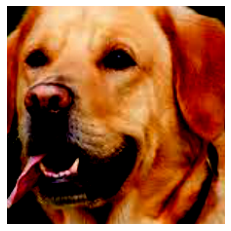

In [242]:


# Run this to test your data loaders
images, labels = next(iter(test_loader))
imshow(images[1], normalize= False)

### Image Dataset from paths

Sometimes, you have given a bunch of paths and labels for your dataset, because it can be not convenient to move images around. 

For this reason, you can create something similar to what we have done at the beginning.

Let's say we have a file called `train.csv` containing the columns `path` and `label`. 

In [243]:
train = pd.DataFrame({"path": ["my_dataset/image1.png", "my_dataset/image2.png"], "label": [0, 1] })

In [244]:
train

,path,label
0,my_dataset/image1.png,0
1,my_dataset/image2.png,1


In [245]:
train.to_csv("data/train.csv")

We can create a custom dataloader as before:

In [246]:
from PIL import Image
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        df = pd.read_csv(csv_file)
        self.paths = df.path.values
        self.labels = df.label.values
    def __getitem__(self, index):
        # we want to be index like dataset[index]
        # to get the index-th batch
        img = Image.open(self.paths[index]).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, self.labels[index]
    
    def __len__(self):
        # to retrieve the total samples by doing len(dataset)
        return len(self.paths)

### Optional/Advanced Exercise

Create the csv file of the style defined above to load the dataset that you have created.

You can customize even more! A nice article for it is:
   https://www.scottcondron.com/jupyter/visualisation/audio/2020/12/02/dataloaders-samplers-collate.html